# FANTASY Tutorial

It is designed by Nemanja Rakić, Dragana Ilić and Luka Č. Popović.

FANTASY stands for Fully Automated pythoN tool for AGN Spectra analYsis. It is a python based open source code for simultaneously fitting multi-component of AGN spectra, optimized for the optical rest-frame band (3600-8000A) but also applicable to the UV range (2000-3600A) and NIR range (8000-11000A).

Here the code tries to simultaneously fit both the underlying broken power-law continuum and sets of defined emission line lists. There is also an option to import and fit together the Fe II model, to fully account for the rich emission of complex Fe II ion which can produce thousands of line transitions, both in the range of Hg and Hb, but also Ha line. 

The code can be used both for fitting a single spectrum or a sample of spectra. It is based on Sherpa Python package (Burke et al. 2022 ).



In [1]:
# Importing some of the standard python packages, such as matplotlib, pandas, numpy, etc. 

import matplotlib.pyplot as plt
#import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import numpy as np
import pandas as pd

import glob


 1. READING THE DATA
   This is the first step. Here we read the data from a spectrum or a set of spectra.
   
    i) read_sdss - this command reads data from SDSS fits (https://www.sdss.org)
    ii) read_gama_fits - this command reads from GAMA fits (http://www.gama-survey.org)
    iii) read_text - this command reads any ASCII files (e.g., wavelength, flux, flux_error)
    iv) make_spec - this command is designed to make Fantasy spectral class from any given three arrays for wavelength, flux,           flux_error; user can also set the redshift and coordinates, which is needed in the later analysis: 
        make_spec(wave, flux, err, z=, ra=, dec=)


In [2]:
# importing the above mentioned reading commands
from fantasy_agn.tools import read_sdss, read_text, read_gama_fits

# importing the necessary commands, which will be described later
from fantasy_agn.models import create_input_folder

from fantasy_agn.models import create_feii_model, create_model, create_tied_model, continuum, create_line, create_fixed_model

In [3]:
# reading the sdss data

s=read_sdss('/home/sagarika/Downloads/spec-0525-52295-0148.fits')


In [4]:
# importing astropy package to view data

import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

s1 = get_pkg_data_filename('/home/sagarika/Downloads/spec-0525-52295-0148.fits')

In [5]:
file=fits.open(s1)
file.info()

Filename: /home/sagarika/Downloads/spec-0525-52295-0148.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     141   ()      
  1  COADD         1 BinTableHDU     26   3842R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


In [6]:
file[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TAI     =        4518160239.07 / 1st row - Number of seconds since Nov 17 1858  
RA      =            198.09360 / 1st row - Right ascension of telescope boresigh
DEC     =            2.273225  / 1st row - Declination of telescope boresight (d
EQUINOX =              2000.00 /                                                
RADECSYS= 'FK5     '           /                                                
TAIHMS  = '12:26:52.95'        / 1st row - TAI time (HH:MM:SS.SS) (TAI-UT = appr
TIMESYS = 'tai     '           / TAI, not UTC                                   
MJD     =                52295 / MJD of observation                             
MJDLIST = '52289 52293 52295

In [7]:
#file[0].data

In [8]:
file[1].data


FITS_rec([(153.8014  , 3.5797, 0.01860676, 67108864, 67108864, 1.3418212 , 10.413443 , 156.73866 ),
          (155.86281 , 3.5798, 0.02700083,        0,        0, 1.3433206 ,  9.122837 , 153.49129 ),
          (151.56984 , 3.5799, 0.02796138,        0,        0, 1.3418168 ,  8.857926 , 155.51881 ),
          ...,
          ( 22.582573, 3.9636, 0.5903289 ,        0,        0, 0.63512814,  6.3496284,  23.425234),
          ( 21.07086 , 3.9637, 0.58885944,        0,        0, 0.6350888 ,  6.3922005,  25.217379),
          ( 23.219793, 3.9638, 0.5596004 ,        0,        0, 0.63565964,  6.450692 ,  25.915499)],
         dtype=(numpy.record, [('flux', '>f4'), ('loglam', '>f4'), ('ivar', '>f4'), ('and_mask', '>i4'), ('or_mask', '>i4'), ('wdisp', '>f4'), ('sky', '>f4'), ('model', '>f4')]))

 2. PREPARATION OF THE SPECTRA

   Before performing the fittings, the FANTASY code provide several preprocessing options to prepare the spectrum, namely:

    To change the wavelength frame from vacuum wavelength to air wavelengths - vac_to_air()
    Galactic extinction correction - DeRedden(), based on Schlegel, Finkbeiner, Davis (1998) dust maps.
    Redshift correction - CorRed()
    Croping of spectra - crop(xmin,xmax)



In [9]:
#OPENING IN TOPCAT I CHECKED THAT REDSHIFT OF THE QSO IS 0.30634505
# read_sdss() transform the wavelengths to air wavelengths by default so we don't need to do it.

In [10]:
# galactic extinction correction
s.DeRedden()

#NOTE: Coordinates of the object provided in the fits are automatically derived from dust map data from 
#Schlegel, Finkbeiner, Davis (1998), so we don't need to find them separately.

In [11]:
# redshift correction
s.CorRed()

In [12]:
print(s.flux)   # in units of 10^-17 ergs/cm^2/s
print(s.wave)  # in units of Angstrom
print(s.z)      # dimensionless

[220.18976  223.13728  216.98776  ...  30.305492  28.276487  31.159964]
[2907.494  2908.1626 2908.8335 ... 7037.5713 7039.1943 7040.8135]
0.30634505


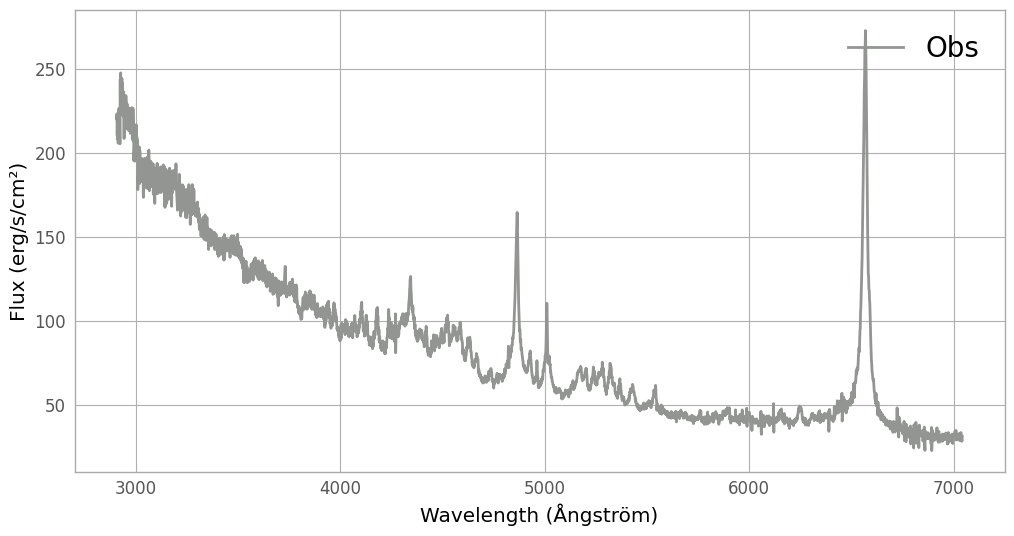

In [13]:
# ploting of the spectrum

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
#plt.xlim(6000,7000)
#plt.ylim(50,300)
plt.xlabel('Wavelength (Ångström)')
plt.ylabel('Flux (erg/s/cm²)')
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.legend(loc='upper right',  prop={'size': 20}, frameon=False, ncol=2)

#do not crop the spectrum before fitting for host galaxy.

# DOUBT: From the plot below there seems to be presence of absorption line, so I should have stellar contribution
# from the host galaxy, but later I see that the host galaxy contribution is coming as negligible. Why so?

 3. HOST-GALAXY SUBSTRACTION

i) The Command fit_host_sdss() fits the observed spectrum using the Principle Component Analysis (PCA) with the optimal combination of 5 eignevectors for the galaxy (stellar) and 10 QSO components, vastly used for SDSS spectra and described in details in Yip et al. (2004) and Vanden Berk et al. (2006) .

ii) The Command fit_host() fits the observed spectrum with PCA which uses all available eigenvectors (10 eignevectors for the galaxy (stellar) and 15 QSO components). In this case the code will test for different number of components until reaching best result based on the chi2 parameter.

In both cases, the weighthed fit is used in order to avoid accounting for strong emission lines. If the host-galaxy contribution is negligible, i.e., the fitting results in a negative host-galaxy, the code will fail to find the host and inform the user.

#IMPORTANT: Code will by default subtract the host galaxy from the observed spectrum; if you need the original spectrum for some analysis, you can restore the original spectrum before the host fitting with the command restore().

    host-galaxy fitting and subtraction - fit_host_sdss()
    host-galaxy fitting and subtraction - fit_host()

TIP: Do not crop the spectrum before fitting for the host galaxy contribution, as the fittings strongly depends on the stellar absorption features that are more likely to be detected in a wider spectral range, i.e. the range in which the eigenvectors are provided (3600-8000A).


In [14]:
# to fit the observed spectrum using the Principle Component Analysis (PCA) 
#with the optimal combination of 5 eignevectors for the galaxy (stellar) and 10 QSO components, 
#vastly used for SDSS spectra and described in details in Yip et al. (2004) and Vanden Berk et al. (2006) . 

s.fit_host_sdss()

Host contribution is negliglable


In [15]:
# to restore the original spectrum before host galaxy fitting and substraction
s.restore() 

In [16]:
#Since host galaxy contribution is negligible, one possibility is to mask the narrow emission lines
#while performing the host galaxy fitting. 
#This is done with setting the option mask_host=True, which by default masks all well known nebular lines
#([O III], [N II], [S II]), but customized list of emission lines can be also given.

s.fit_host_sdss(mask_host=True, custom=False)

Host contribution is negliglable


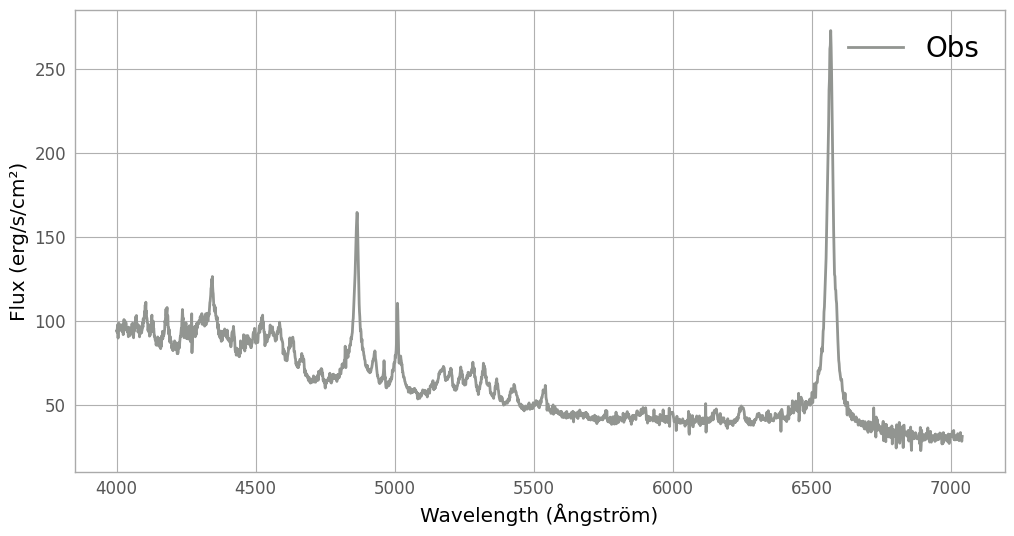

In [51]:
#Let's plot the spectrum again for visual inspection.

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.xlabel('Wavelength (Ångström)')
plt.ylabel('Flux (erg/s/cm²)')
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.legend(loc='upper right',  prop={'size': 20}, frameon=False, ncol=2)


In [18]:
# It is obvious, e.g. based on the strong blue continuum and absence of absorption line, that the stellar contribution
# from the host galaxy can be negligible.

# If there are presence of stars or star forming regions, there will be absorption lines. 
#Since there is no visible absorption line in the spectrum, then the stellar contribution
# from the host galaxy can be negligible.

 4. CREATION OF PREDEFINED EMISSION LINES

Within FANTASY there are some standard lists of AGN emission lines, such as: Hydrogen lines (e.g., Ha, Hb, Hg, Hd, Pa, Pb, Pg, Pd), Helium lines (both He I and He II), basic narrow lines ([OIII], [NII]), other AGN narrow lines, other AGN broad lines, Fe II lines, coronal lines, etc.

The command create_input_folder(xmin,xmax,path_to_folder) creates a folder in the specified path, copies the predefined line lists within the specified wavelength range.


In [19]:
#Creation of a folder with the predefined lists of emission lines 
create_input_folder(xmin=3500,xmax=8000, path_to_folder='lines1/')

Directory  lines1/  already exists


In [20]:
s.crop(4000, 8000)   
print(s.wave) # simple examine of the wavelength range

#DOUBT: how does it know or understand that it has to crop THE wavelength axis?
# Ans: Crop function cuts the spectrum in a set wavelength range

[4000.5652 4001.4854 4002.406  ... 7037.5713 7039.1943 7040.8135]


 5. DEFINING THE FITTING MODEL

Any basic model for AGN spectra fittings contains:

    i) underlying continuum (broken power-law, power-law, streight line)
    ii) emission line (narrow, broad)

Description of the fitting components:

    i) continuum() - it calls BrokenPowerlaw() model for a given breaking point (the parameter 'refer' indicates the breaking wavelength); note that the continuum amplitude is then automatically set based on the flux value at the breaking point.

    ii) create_fixed_model - this calls for all lines from the indicated list haveing the same width and shift; users can specify common name for these lines (parameter name).

    iii) create_tide_model - this one calls for all lines having width and shift tided to the reference line (typically [OIII] 5007 line); user can specify common name for these lines (parameter prefix).

    iv) create_feii_model - it calls for the FeII model where all iron lines have the same width and shift.

    v) create_line - calls for a single line at the given wavelength (parameter position), it is possible for the user to set width (fwhm), shift (offset) and intensity (ampl).

    vi) create_model - it calls all the lines from the indicated list, but no parameter is constrained.

For multi-line models, user can call a single line-list and many line-lists using the option files=['list1.csv','list2.csv'].


In [21]:
# Defining Models

cont=continuum(s,min_refer=5690, refer=5700, max_refer=5710)
broad=create_fixed_model(['hydrogen.csv'], name='br_h') #BLR
#broad2=create_fixed_model(['hydrogen.csv'], name='br_h2',fwhm=5000, min_fwhm=4000, max_fwhm=11000) #VeryBLR
he=create_fixed_model(['helium.csv'], name='he',fwhm=3000, min_fwhm=1000, max_fwhm=6000)
narrow=create_tied_model(name='OIII5007',files=['narrow_basic.csv','hydrogen.csv'],prefix='nr_',fwhm=1000,min_offset=0, max_offset=300, min_fwhm=700, max_fwhm=1200,fix_oiii_ratio=True, position=5006.803341, included=True,min_amplitude=0.2)
fe=create_feii_model(name='feii', fwhm=1800, min_fwhm=1000, max_fwhm=2000, offset=0, min_offset=-3000, max_offset=3000)

#fe.amp_b4p.min=10 #An example how to force the amplitude of a selected FeII multiplet.

In [22]:
# Code fits simultaneously all the features.
model = cont+broad+narrow+he+fe#+broad2

 6. FITTINGS

The command s.fit() is used to fit the spectrum with the model given above. It is based on Python Sherpa package.The Code offers the possibility to set the number of consequent fittings (option ntrial) to increase the convergence, given with the chi2, which is listed.


In [80]:
s.fit(model, ntrial=2)     #here we tried fitting with two trials

stati 0.5631381281755239
1 iter stat:  0.5031350502131318
2 iter stat:  0.4517661637537458


7. PLOTTING OF THE RESULTS

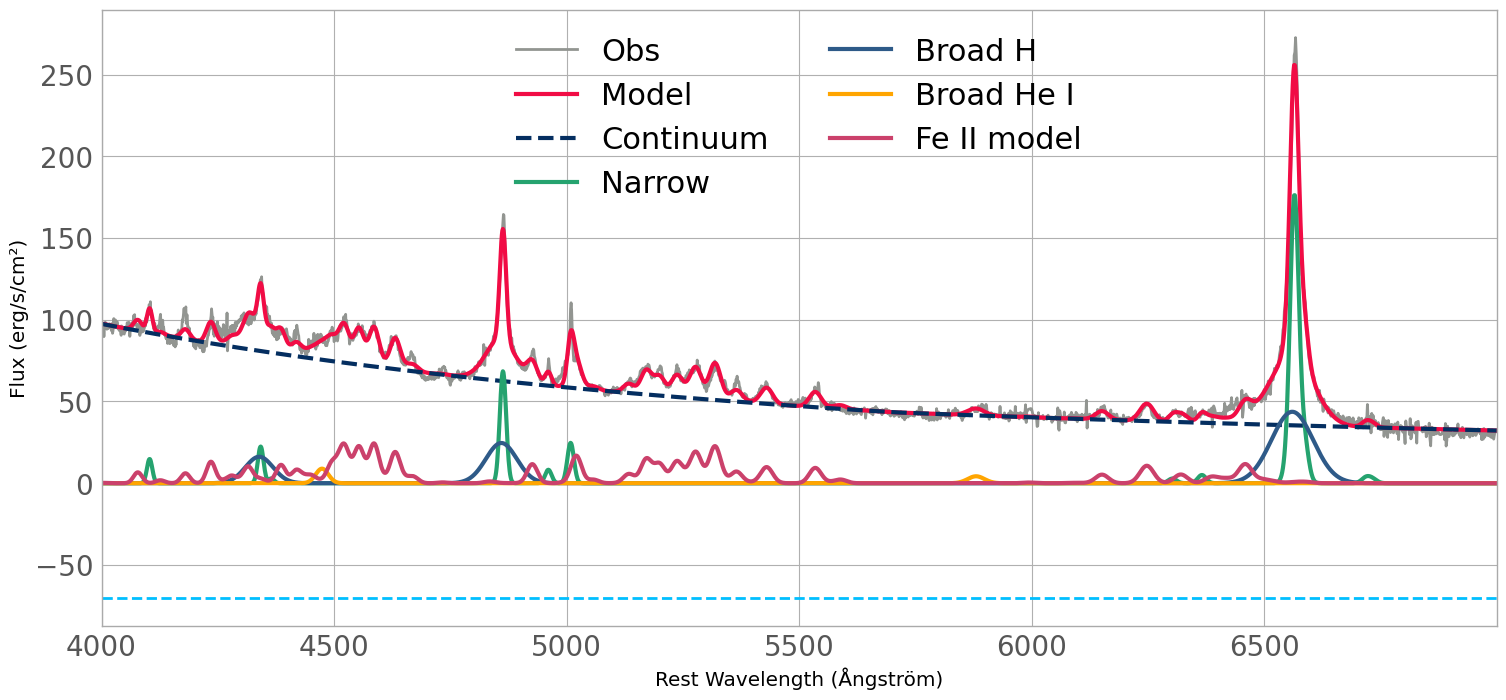

In [81]:
#plotting

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(18,8))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.plot(s.wave, model(s.wave), color="#F10C45",label='Model',lw=3)
#plt.plot(s.wave, model(s.wave)-s.flux-70, '-',color="#929591", label='Residual', lw=2)     #plotted it separately later for better view
plt.axhline(y=-70, color='deepskyblue', linestyle='--', lw=2)

plt.plot(s.wave, cont(s.wave),'--',color="#042E60",label='Continuum', lw=3)
plt.plot(s.wave, narrow(s.wave),label='Narrow',color="#25A36F",lw=3)
plt.plot(s.wave, broad(s.wave), label='Broad H', lw=3, color="#2E5A88")
plt.plot(s.wave, he(s.wave), label='Broad He I', lw=3, color="orange")
plt.plot(s.wave, fe(s.wave),'-',color="#CB416B",label='Fe II model', lw=3)
#plt.plot(s.wave, broad2(s.wave),'--',label='broad2', lw=3)

plt.xlabel('Rest Wavelength (Ångström)')
plt.ylabel('Flux (erg/s/cm²)')
plt.xlim(4000,7000)
#plt.ylim(-150,900)
plt.tick_params(which='both', direction="in")
plt.yticks(fontsize=20)
plt.xticks(np.arange(4000, 7000, step=500),fontsize=20)
plt.legend(loc='upper center',  prop={'size': 22}, frameon=False, ncol=2)

#plt.savefig('fantasy_fit.pdf')

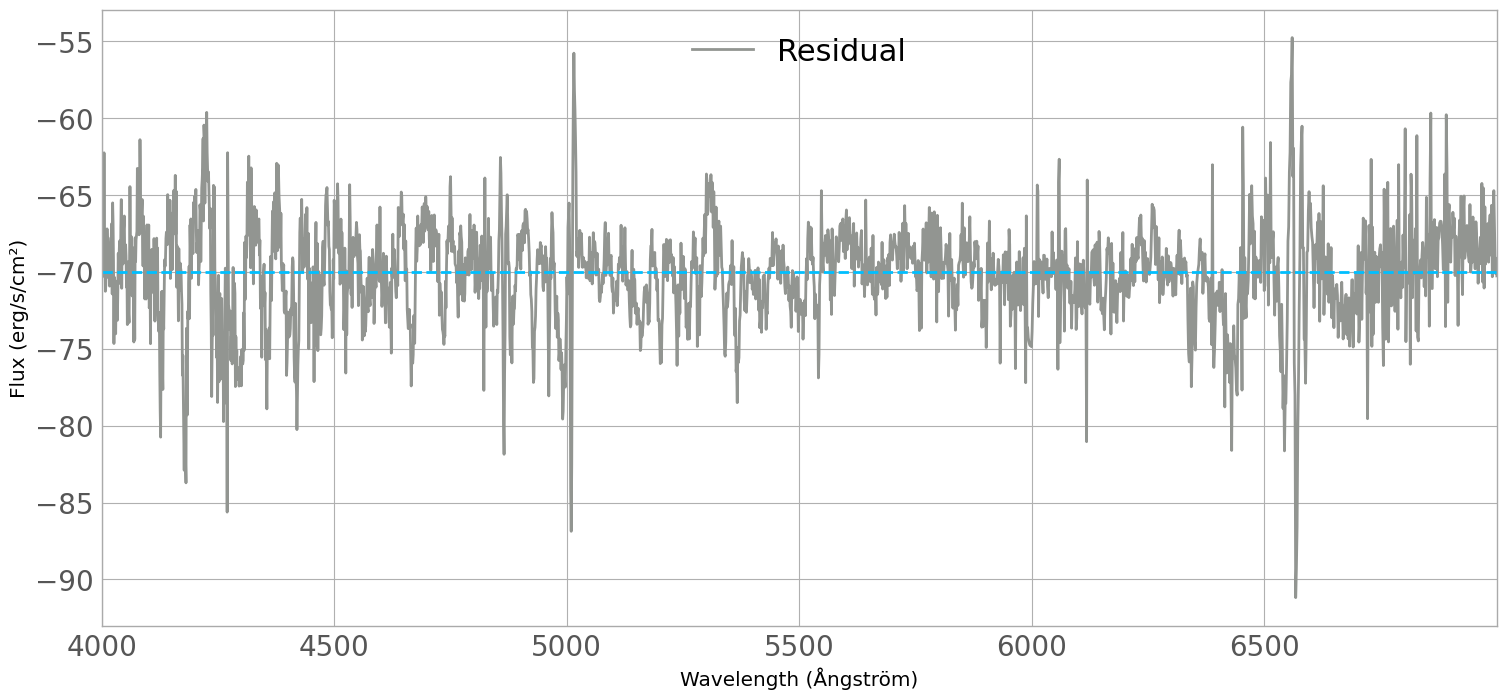

In [82]:
# plotting of the residual

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(18,8))
plt.plot(s.wave, model(s.wave)-s.flux-70, '-',color="#929591", label='Residual', lw=2)
plt.axhline(y=-70, color='deepskyblue', linestyle='--', lw=2)

plt.xlabel('Wavelength (Ångström)')
plt.ylabel('Flux (erg/s/cm²)')
plt.xlim(4000,7000)
#plt.ylim(-150,900)
plt.tick_params(which='both', direction="in")
plt.yticks(fontsize=20)
plt.xticks(np.arange(4000, 7000, step=500),fontsize=20)
plt.legend(loc='upper center',  prop={'size': 22}, frameon=False, ncol=2)

 8. INSPECTING AND SAVING THE PLOTTING RESULTS

To examine the fitting results the command model is used which displays all parameters for each emission line. 

In [83]:
model

<BinaryOpModel model instance '((((brokenpowerlaw + br_h) + (((((((((((((((((nr__OIII5007 + nr__OIII4958) + nr__NII6584) + nr__NIII6548) + nr__[OII]_3726) + nr__[OII]_3728) + nr__[NeIII]_3868) + nr__[OIII]_4363) + nr__[OI]_6300) + nr__[OI]_6363) + nr__[SII]_6716) + nr__[SII]_6730) + nr__[OII]_7330) + nr__Heps_3970) + nr__Hd_4101) + nr__Hg_4340) + nr__Hb_4861) + nr__Ha_6562)) + he) + feii)'>

In [84]:
# To see the fitting results, one can use standard outputs from Sherpa package, such as:
# gres - to list all fitting results
# gres.parnames - to list all parameters
# save_json() - to save the results

print(s.gres.format())
s.save_json() #saving parameters 

Method                = levmar
Statistic             = chi2
Initial fit statistic = 7097.35
Final fit statistic   = 7096.9 at function evaluation 874
Data points           = 2456
Degrees of freedom    = 2399
Probability [Q-value] = 0
Reduced statistic     = 2.95827
Change in statistic   = 0.451766
   brokenpowerlaw.refer   5710         +/- 21.7226     
   brokenpowerlaw.ampl   43.3092      +/- 0.325928    
   brokenpowerlaw.index1   -2.27995     +/- 0.0114492   
   brokenpowerlaw.index2   0.828907     +/- 0.0288158   
   br_h.amp_Heps_3970   0            +/- 1.66437     
   br_h.amp_Hd_4102   0            +/- 0.673776    
   br_h.amp_Hg_4340   16.1932      +/- 0.837986    
   br_h.amp_Hb_4861   24.6052      +/- 0.412642    
   br_h.amp_Ha_6563   43.7108      +/- 0.738616    
   br_h.offs_kms   -93.8146     +/- 16.7747     
   br_h.fwhm      4818.33      +/- 47.5579     
   nr__OIII5007.ampl   24.6932      +/- 0.571342    
   nr__OIII5007.offs_kms   123.942      +/- 3.30455     
   nr__

In [85]:
# reading the saved file which is in .json format

import json
f=open('/home/sagarika/Downloads/spec-0525-52295-0148_pars.json')

In [86]:
data = json.load(f)
data

{'brokenpowerlaw.refer': 5709.997665759968,
 'brokenpowerlaw.ampl': 43.309173323771645,
 'brokenpowerlaw.index1': -2.279945106444388,
 'brokenpowerlaw.index2': 0.8289067084295114,
 'br_h.amp_Heps_3970': 0.0,
 'br_h.amp_Hd_4102': 0.0,
 'br_h.amp_Hg_4340': 16.193180410002565,
 'br_h.amp_Hb_4861': 24.605240191624752,
 'br_h.amp_Ha_6563': 43.71084168931279,
 'br_h.offs_kms': -93.81457822539303,
 'br_h.fwhm': 4818.332520802857,
 'nr__OIII5007.ampl': 24.693203533558556,
 'nr__OIII5007.offs_kms': 123.94153501374001,
 'nr__OIII5007.fwhm': 993.7466091976726,
 'nr__NII6584.ampl': 25.549288197201452,
 'nr__[OII]_3726.ampl': 2.0,
 'nr__[OII]_3728.ampl': 2.0,
 'nr__[NeIII]_3868.ampl': 2.0,
 'nr__[OIII]_4363.ampl': 2.9022390464211365,
 'nr__[OI]_6300.ampl': 2.8411717752439363,
 'nr__[OI]_6363.ampl': 5.01733397914768,
 'nr__[SII]_6716.ampl': 3.388108487438329,
 'nr__[SII]_6730.ampl': 2.366603047423873,
 'nr__[OII]_7330.ampl': 2.0,
 'nr__Heps_3970.ampl': 0.0,
 'nr__Hd_4101.ampl': 14.804062033927899,
 

In [87]:
# Plotting of the emission lines

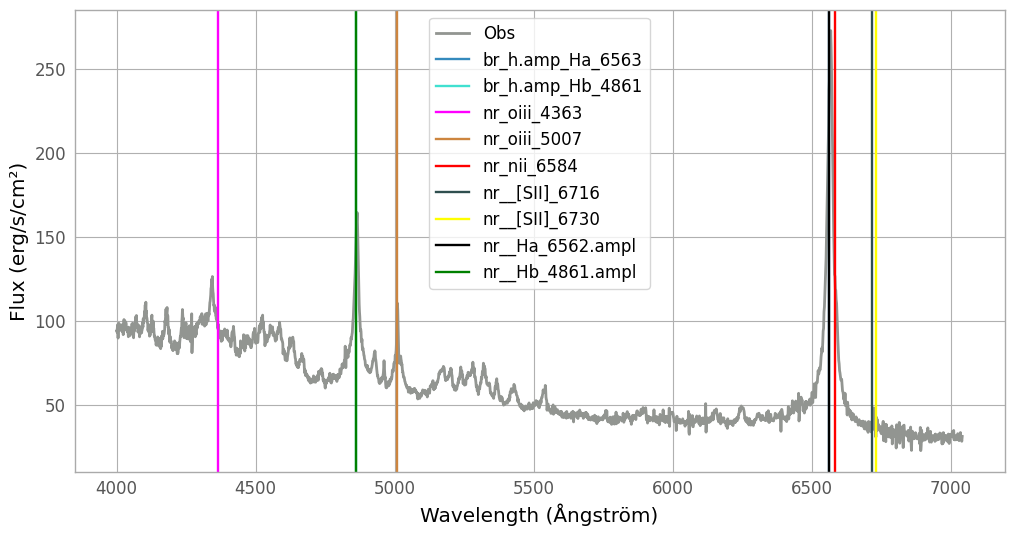

In [88]:
#Let's plot the spectrum for visual inspection.

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.legend(loc='upper right',  prop={'size': 20}, frameon=False, ncol=2)

#broad H aplha
plt.axvline(x = 6563 , label = 'br_h.amp_Ha_6563')
#plt.axvline(x = 6400, label = 'br_h2.amp_Ha_6563_min')
#plt.axvline(x = 6700, label = 'br_h2.amp_Ha_6563_max')


#broad H beta
plt.axvline(x = 4861, color = 'turquoise', label = 'br_h.amp_Hb_4861')
#plt.axvline(x = 4800, color = 'r', label = 'br_h2.amp_Hb_4861_min')
#plt.axvline(x = 4945, color = 'r', label = 'br_h2.amp_Hb_4861_max')


#narrow [oiii] 4363
plt.axvline(x = 4363,color = 'magenta', label = 'nr_oiii_4363')
#plt.axvline(x = 4360,color = 'magenta', label = 'nr_oiii_4363')
#plt.axvline(x = 4365,color = 'magenta', label = 'nr_oiii_4363')


#narrow oiii 5007
plt.axvline(x = 5007,color = 'peru', label = 'nr_oiii_5007')
#plt.axvline(x = 4965,color = 'peru', label = 'nr_oiii_5007')
#plt.axvline(x = 5050,color = 'peru', label = 'nr_oiii_5007')


#narrow NII
plt.axvline(x = 6584,color = 'red', label = 'nr_nii_6584')
#plt.axvline(x = 6586,color = 'red', label = 'nr_nii_6584')
#plt.axvline(x = 6582,color = 'red', label = 'nr_nii_6584')



#nr__[SII]_6716
#plt.xlim(6700, 6750)
plt.axvline(x = 6716,color = 'darkslategrey', label = 'nr__[SII]_6716')
#plt.axvline(x = 6715,color = 'darkslategrey', label = 'nr__[SII]_6716')
#plt.axvline(x = 6718,color = 'darkslategrey', label = 'nr__[SII]_6716')


#nr__[SII]_6730
plt.axvline(x = 6730,color = 'yellow', label = 'nr__[SII]_6730')


#narrow H alpha
plt.axvline(x = 6562,color = 'black', label = 'nr__Ha_6562.ampl')


#narrow H beta
plt.axvline(x = 4861,color = 'green', label = 'nr__Hb_4861.ampl')

plt.xlabel('Wavelength (Ångström)')
plt.ylabel('Flux (erg/s/cm²)')
plt.legend()


 9. SIMPLE ANALYSIS

i) Here we demonstrate how to measure the fluxes of a model component.


In [89]:
#Line flux of narrow H alpha
x=s.wave

mask_ha=(x>6400)&(x<6700)

flux_Ha_narrow=np.sum(narrow(s.wave)[mask_ha])

print('Flux of Narrow Ha=',flux_Ha_narrow)

Flux of Narrow Ha= 3162.9812


In [90]:
#Line flux of narrow H beta

mask_hb=(x>4800)&(x<4945)

flux_Hb_narrow=np.sum(narrow(s.wave)[mask_hb])

print('Flux of Narrow Hb=',flux_Hb_narrow)

Flux of Narrow Hb= 1051.3923


In [91]:
#Line flux of broad H alpha


mask_ha=(x>6400)&(x<6700)

flux_Ha_broad=np.sum(broad(s.wave)[mask_ha])

print('Flux of Broad Ha=',flux_Ha_broad)

Flux of Broad Ha= 3245.4612


In [92]:
#Line flux of broad H beta


mask_hb=(x>4800)&(x<4945)

flux_Hb_broad=np.sum(broad(s.wave)[mask_hb])

print('Flux of Broad Hb=',flux_Hb_broad)

Flux of Broad Hb= 1751.9329


In [93]:
#Line flux of narrow [OIII] 4363

mask_oiii_4363=(x>4360)&(x<4365)

flux_oiii_narrow=np.sum(narrow(s.wave)[mask_oiii_4363])

print('Flux of Narrow oiii_4363=',flux_oiii_narrow)

Flux of Narrow oiii_4363= 13.581215


In [94]:
#Line flux of narrow OIII 5007

mask_oiii_5007=(x>4965)&(x<5050)

flux_oiii_narrow_5007=np.sum(narrow(s.wave)[mask_oiii_5007])

print('Flux of Narrow oiii_5007=',flux_oiii_narrow_5007)

Flux of Narrow oiii_5007= 417.22153


In [95]:
#Line flux of narrow NII

mask_nii=(x>6584)&(x<6586)

flux_nii_narrow=np.sum(narrow(s.wave)[mask_nii])

print('Flux of Narrow nii=',flux_nii_narrow)

Flux of Narrow nii= 46.134125


In [96]:
#Line flux of narrow [SII] 6716

mask_sii_6716=(x>6715)&(x<6718)

flux_sii_narrow=np.sum(narrow(s.wave)[mask_sii_6716])

print('Flux of Narrow sii_6716=',flux_sii_narrow)

Flux of Narrow sii_6716= 7.5890326


In [97]:
#Line flux of narrow [SII] 6730

mask_sii_6730=(x>6725)&(x<6732)

flux_sii_narrow=np.sum(narrow(s.wave)[mask_sii_6730])

print('Flux of Narrow sii_6730=',flux_sii_narrow)

Flux of Narrow sii_6730= 20.470833


In [98]:
flux_feII=np.sum(fe(s.wave))
print('Total Flux of FeII=',flux_feII)

Total Flux of FeII= 9637.829


ii) calculation of line ratios and checking where they stand on BPT diagram.

 The BPT (Baldwin-Phillips-Terlevich) diagram is a diagnostic tool mainly used to classify  AGNs by determining the ionization state of the gas in the Narrow-Line Region (NLR) of galaxies.
 The BPT diagram is a plot of the [O III]λ5007/Hβ and [N II]λ6584/Hα emission line ratios. These ratios are used to distinguish between AGN and star-forming galaxies, as the emission lines in these two types of galaxies have different ionization mechanisms.
 The diagram is divided into four quadrants corresponding to different ionisation source. The lower left quadrant is dominated by star-forming galaxies, while the upper right quadrant is dominated by AGN. The two intermediate quadrants, the lower right and the upper left, are referred to as the composite region; they contain galaxies with both AGN and star-forming activities. 
 It is used to study the properties and evolution of AGN, and their impact on the host galaxy. It is also useful for identifying AGN that may be obscured by dust or other factors, as their emission lines will be shifted towards the star-forming region on the diagram.
 Below is a picture of a BPT diagram.

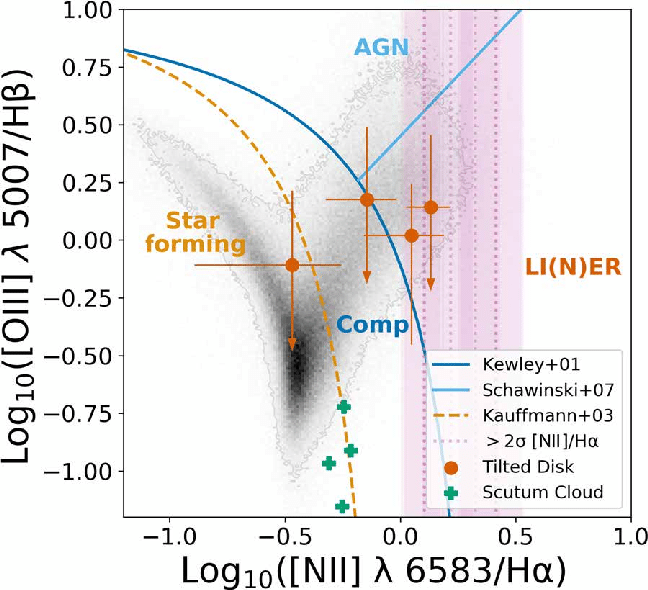

In [99]:
# calculating line ratio of [NII]6583/Ha

ratio_nii_ha = flux_nii_narrow/flux_Ha_narrow
print("[NII]6583/Ha = ",ratio_nii_ha )

[NII]6583/Ha =  0.014585646


In [100]:
# calculating line ratio of [OIII]5007/Hb

ratio_oiii_hb=flux_oiii_narrow_5007/flux_Hb_narrow
print('[OIII]5007/Hb = ',ratio_oiii_hb)

[OIII]5007/Hb =  0.39682764


In [101]:
# taking log values of the ratios to see where they are placed on the BPT diagram
np.log10(ratio_oiii_hb)

-0.4013981

In [102]:
np.log10(ratio_nii_ha)

-1.8360744

From the above calculated values we see that the point (-1.84,-0.4) lies in the lower left quadrant. So the observed type 1 AGN falls in the star forming region of the BPT diagram.
DOUBT: (which probably should be the case since there are absorption lines are present)

iii) Measuring the Ha/Hb ratio in the observed galaxy (host galaxy contribution is not present as obtained before)

In [103]:
# for narrow emission lines

ratio_narrow = flux_Ha_narrow/flux_Hb_narrow
print("Ha_narrow/Hb_narrow = ",ratio_narrow )

Ha_narrow/Hb_narrow =  3.0083737


In [104]:
# for broad emission lines

ratio_broad = flux_Ha_broad/flux_Hb_broad
print("Ha_broad/Hb_broad = ",ratio_broad )

Ha_broad/Hb_broad =  1.8525032
